In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.37'

In [3]:
from fastai import *
from fastai_audio import *

In [4]:
DATA = Path('data')
NSYNTH_AUDIO = DATA/'nsynth_audio' # contains train and valid folders

In [5]:
def save_poly_frames_df(df, name):
    frames_np = np.stack(df['frame'].values)
    np.save(name + '.npy', frames_np)
    df[['pitches', 'n_pitches']].to_csv(name + '.csv', index=False)
    
def load_poly_frames_df(name):
    df = pd.read_csv(name + '.csv')
    # convert string column back to list of ints
    df['pitches'] = df['pitches'].apply(lambda s: list(map(int, s[1:-1].split(' '))))
    frames_np = np.load(name + '.npy')
    list_frames = np.array_split(frames_np, frames_np.shape[0])
    df['frame'] = pd.Series(map(np.squeeze, list_frames))
    return df

In [6]:
tst_frames_poly = load_poly_frames_df('tst_frames_poly_1024_6')

In [7]:
val_frames_poly = load_poly_frames_df('val_frames_poly_1024_6')

In [8]:
trn_frames_poly = load_poly_frames_df('trn_frames_poly_1024_6')

In [9]:
len(tst_frames_poly), len(val_frames_poly), len(trn_frames_poly)

(2968, 9265, 126475)

In [10]:
class SimpleModel(nn.Module):
    def __init__(self, n_inputs, n_classes):
        super().__init__()
        self.layers = nn.Sequential(
            *bn_drop_lin(n_inputs, 1024, actn=nn.ReLU(inplace=True), p=0.2),
            *bn_drop_lin(1024, 512, actn=nn.ReLU(inplace=True), p=0.2),
            *bn_drop_lin(512, n_classes, actn=None),
        )
    def forward(self, x):
        return self.layers(x)

In [11]:
trn_list = AudioFrameList.from_df(trn_frames_poly, NSYNTH_AUDIO, cols=2)
val_list = AudioFrameList.from_df(val_frames_poly, NSYNTH_AUDIO, cols=2)

In [12]:
n_fft = trn_frames_poly.iloc[0]['frame'].shape[0]
to_db = ToDecibels(ref=1.0, top_db=50.0)
window = to_device(torch.hann_window(n_fft).unsqueeze_(0), None)

def batch_fft(inputs):
    xs, ys = inputs
    xs = torch.rfft(xs * window, 1, normalized=True).pow_(2.0).sum(-1)
    xs = to_db(xs)
    return xs, ys

batch_tfms = [batch_fft]

In [13]:
bs = 128

data = (ItemLists(NSYNTH_AUDIO, trn_list, val_list)
            .label_from_df('pitches')
            .databunch(bs=bs, tfms=batch_tfms))
xs, ys = data.one_batch()
xs.shape, ys.shape

(torch.Size([128, 513]), torch.Size([128, 48]))

In [24]:
class SimpleModel(nn.Module):
    def __init__(self, n_inputs, n_classes):
        super().__init__()
        self.layers = nn.Sequential(
            *bn_drop_lin(n_inputs, 1024, actn=nn.ReLU(inplace=True)),
#             *bn_drop_lin(1024, 2048, actn=nn.ReLU(inplace=True)),
#             *bn_drop_lin(2048, 1024, actn=nn.ReLU(inplace=True)),
            *bn_drop_lin(1024, 512, actn=nn.ReLU(inplace=True)),
            *bn_drop_lin(512, 512, actn=nn.ReLU(inplace=True)),
#             *bn_drop_lin(512, 512, actn=nn.ReLU(inplace=True)),
            *bn_drop_lin(512, n_classes, actn=None),
        )
    def forward(self, x):
        return self.layers(x)

In [25]:
in_size = n_fft//2 + 1
print('in_size: ', in_size)

model = SimpleModel(in_size, data.c)
learn = Learner(data, model, metrics=[fbeta])
# learn.summary()

in_size:  513


In [26]:
model_name = 'polyphonic_pitch_v1'

In [27]:
learn.fit_one_cycle(4)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,fbeta
1,0.117892,0.096946,0.797311
2,0.100947,0.079758,0.840105
3,0.088920,0.069862,0.863985
4,0.078408,0.066340,0.871629


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


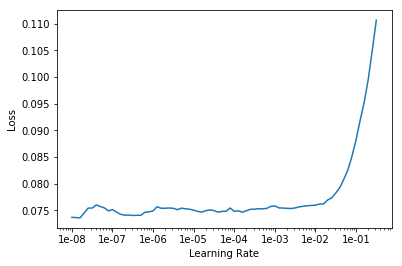

In [28]:
learn.load(model_name + '-stage-1')
learn.lr_find(start_lr=1e-9)
learn.recorder.plot()

In [29]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(16, max_lr=1e-4)
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,fbeta
1,0.075642,0.066039,0.872157
2,0.075850,0.066417,0.871005
3,0.075111,0.066147,0.872567
4,0.075745,0.065725,0.872845
5,0.074268,0.066152,0.872209
6,0.073244,0.066194,0.871668
7,0.073006,0.066120,0.871853
8,0.073142,0.065934,0.872064
9,0.071537,0.065928,0.871733
10,0.070454,0.065841,0.871785


In [30]:
thresholds = np.linspace(0.1, 0.9, 20)
val_preds = learn.get_preds(DatasetType.Valid)
trn_preds = learn.get_preds(DatasetType.Train)

val_fbetas = []
trn_fbetas = []

for t in thresholds:
    val_fbetas.append(fbeta(*val_preds, thresh=t))
    trn_fbetas.append(fbeta(*trn_preds, thresh=t))

In [40]:
learn.get_preds?

Signature:
learn.get_preds(
    ['ds_type:fastai.basic_data.DatasetType=<DatasetType.Valid: 2>', 'with_loss:bool=False', 'n_batch:Union[int, NoneType]=None', 'pbar:Union[fastprogress.fastprogress.MasterBar, fastprogress.fastprogress.ProgressBar, NoneType]=None'],
) -> List[torch.Tensor]
Docstring: Return predictions and targets on `ds_type` dataset.
File:      /opt/anaconda3/lib/python3.6/site-packages/fastai/basic_train.py
Type:      method


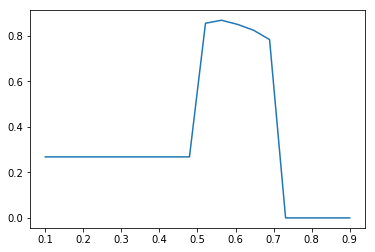

In [31]:
plt.plot(thresholds, val_fbetas)

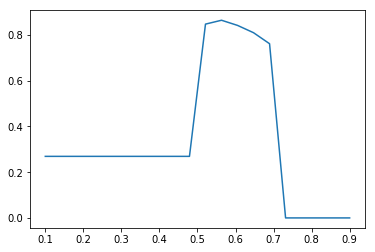

In [32]:
plt.plot(thresholds, trn_fbetas)

In [33]:
max(val_fbetas), max(trn_fbetas)

(tensor(0.8682), tensor(0.8645))

In [35]:
vpreds = [v.numpy() for v in val_preds]
tpreds = [t.numpy() for t in trn_preds]

In [39]:
vpreds[0].shape, vpreds[1].shape

((9265, 48), (9265, 48))

In [44]:
tpreds[0].shape, tpreds[1].shape

((126464, 48), (126464, 48))

In [41]:
def save_preds(name, preds):
    np.save(name+'_preds.npy', preds[0])
    np.save(name+'_targs.npy', preds[1])

In [42]:
save_preds('valid_polyphonic_1024_6', vpreds)

In [43]:
save_preds('train_polyphonic_1024_6', tpreds)

### Use the model

In [35]:
from IPython.display import Audio
from utils import read_file
filename = 'data/recorded/e_major_chord.wav'
x, sr = read_file(filename)
x.shape, sr

((241152,), 16000)

In [36]:
Audio(x, rate=sr)

In [37]:
frame_len = 1024
n_frames = x.shape[0] // frame_len
frames = [x[n*frame_len:(n+1)*frame_len] for n in range(n_frames)]
len(frames), frames[0].shape

(235, (1024,))

In [38]:
%time

preds = []
for frame in frames:
    pred = learn.predict(AudioFrame(frame))[0].obj
    preds.append(pred)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


In [39]:
preds

[[40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47, 52],
 [40, 47, 52],
 [40, 47, 52],
 [40, 47, 52],
 [40, 47, 52],
 [40, 47, 52],
 [40, 47, 52],
 [40, 47, 52],
 [40, 47, 52],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47],
 [40, 47, 52],
 [40, 47, 52],
 [40, 47, 56],
 [40, 47, 56],
 [40, 47, 56],
 [40, 47, 56],
 [40, 47, 56],
 [40, 47, 56],
 [40, 47, 56],
 [40, 47, 56],
 [40, 47, 56],
 [40, 47, 56],
 [40, 47, 56],
 [40, 47, 56],
 [40, 47, 48, 56],
 [40, 47, 56],
 [40, 47, 56],
 [40, 47, 48, 56],
 [40, 44, 45, 56, 59],
 [40, 47, 56, 59],
 [40, 56, 59],
 [40, 45, 56, 59],
 [40, 56, 59],
 [40, 56, 59],
 [40, 56, 59],
 [40, 56, 59],
 [40, 56, 59],
 [40, 56, 59],
 [40, 46, 47, 56, 59],
 [40, 56, 59],
 [40, 47, 56, 59],
 [40, 47, 56, 59],
 [40, 47, 56, 59],
 [40,

In [40]:
filename = 'data/recorded/e_octaves.wav'
x, sr = read_file(filename)
x.shape, sr

((90508,), 16000)

In [41]:
Audio(x, rate=sr)

In [42]:
frame_len = 1024
n_frames = x.shape[0] // frame_len
frames = [x[n*frame_len:(n+1)*frame_len] for n in range(n_frames)]
len(frames), frames[0].shape

(88, (1024,))

In [43]:
%time

preds = []
for frame in frames:
    pred = learn.predict(AudioFrame(frame))[0].obj
    preds.append(pred)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 23.1 µs


In [44]:
preds

[[40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [],
 [40],
 [40],
 [40],
 [],
 [],
 [],
 [59],
 [],
 [59],
 [],
 [52],
 [52],
 [52],
 [52],
 [52],
 [52],
 [52],
 [52],
 [52],
 [52],
 [52],
 [52],
 [52],
 [52],
 [52],
 [52],
 [],
 [44, 52],
 [52],
 [52],
 [64],
 [52],
 [52],
 [52],
 [],
 [],
 [],
 [],
 [64],
 [],
 [],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40],
 [40, 52],
 [40, 52],
 [40, 52],
 [40],
 [40],
 [40],
 [40, 47]]